In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
# Define the style of the box style
boxplot_property = {
    "vert": True,
    "whis": 100,
    "patch_artist": True,
    "widths": 0.5,
    "rot": 90,
    "boxprops": dict(linewidth=3, color="black", alpha=0.9),
    "medianprops": dict(linewidth=2.5, color="black", alpha=0.9),
    "whiskerprops": dict(linewidth=3, color="black", alpha=0.9),
    "capprops": dict(linewidth=3, color="black", alpha=0.9),
}

In [1]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data.head()

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000


# Lineal model: the Newton's second law.


$$P_{meca}=\beta_1V_d^3+\beta_2V_d+\beta_3\sin(\alpha)V_d+\beta_4\alpha V_d$$

In [46]:
import numpy as np

data["speed3"] = data["speed"].apply(lambda x: x**3)
data["speed_sin"] = data[["speed", "slope"]].apply(lambda x: x[0]*np.sin(np.arctan(x[1])), axis=1)
data["speed_acceleration"] = data[["speed", "acceleration"]].apply(lambda x: x[0]*np.clip(x[1],0,5), axis=1)

data_model = data[["speed3", "speed", "speed_sin", "speed_acceleration"]]

In [47]:
data_model.describe()

,speed3,speed,speed_sin,speed_acceleration
count,38254.000000,38254.000000,38254.000000,38254.000000
mean,716.713830,8.203325,-0.002710,0.571451
std,631.602968,2.603563,0.249192,1.082863
min,0.000000,0.000000,-1.803089,0.000000
25%,284.760443,6.579000,0.000000,0.000000
50%,571.167214,8.297000,0.000000,0.045422
75%,962.674280,9.874000,0.076831,0.694669
max,6439.008413,18.604000,1.427276,21.015078


In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error


cv = ShuffleSplit(n_splits=4)
model = make_pipeline(StandardScaler(), RidgeCV())

cv_result = cross_validate(model, data_model, target, cv=cv, 
                            return_estimator=True, return_train_score=True, n_jobs=-1,
                            scoring="neg_mean_absolute_error")



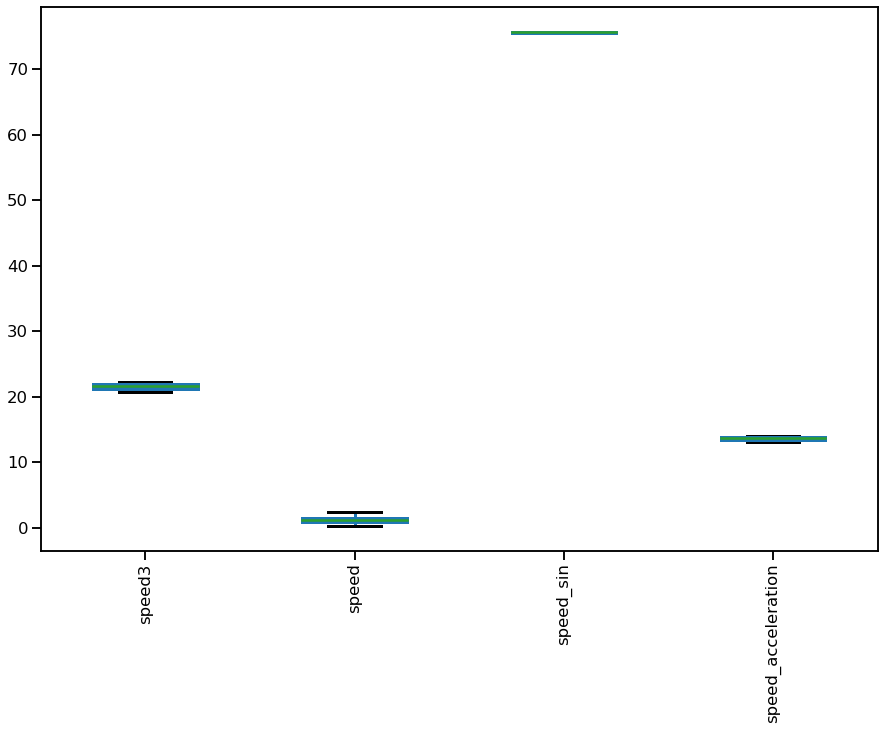

In [72]:
coefs = [estimator[-1].coef_ for estimator in cv_result["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_model.columns)
_, ax = plt.subplots(figsize=(15, 10))
coefs.abs().plot.box(**boxplot_property, ax=ax)

# Hist Gradient Boosting Regressor

In [165]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42
)

cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True, n_jobs=2)

errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

MAE on test sets:
 [44.65031497 44.1322343  44.03475175 43.21669828]
 mean +/- std: 44.008 +/- 0.514 Watts


In [166]:
errors = -cv_result["train_score"]
print(f"Linear model - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_result["test_score"]
print(f"Linear model - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

errors = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Linear model - MAE on train sets:
 [72.59902469 72.58878472 72.68405713 72.20818647]
 mean +/- std: 72.520 +/- 0.184 Watts
Linear model - MAE on test sets:
 [71.57449991 71.39416329 70.8627264  74.69815359]
 mean +/- std: 72.132 +/- 1.504 Watts
Histogram GBDT - MAE on train sets:
 [40.52206579 40.18916531 40.43827918 37.88848782]
 mean +/- std: 39.759 +/- 1.087 Watts
Histogram GBDT - MAE on test sets:
 [44.65031497 44.1322343  44.03475175 43.21669828]
 mean +/- std: 44.008 +/- 0.514 Watts


# Split croos validation: LeaveOneGroipOut

In [167]:

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


In [168]:
date = pd.factorize(data_model.index.date)[0]

In [169]:
cv = LeaveOneGroupOut()
model = make_pipeline(StandardScaler(), RidgeCV())

cv_result = cross_validate(model, data_model, target, cv=cv, 
                            return_estimator=True, return_train_score=True, n_jobs=-1,
                            scoring="neg_mean_absolute_error", groups=date)

In [170]:
hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42
)

cv_ghbdt = LeaveOneGroupOut()
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv_ghbdt, scoring="neg_mean_absolute_error",
    return_estimator=True, groups=date, return_train_score=True, n_jobs=2)

In [172]:
errors = -cv_result["train_score"]
print(f"Linear model - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_result["test_score"]
print(f"Linear model - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

errors = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
errors = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")

Linear model - MAE on train sets:
 [72.4317474  72.28702403 68.96505889 75.31150408]
 mean +/- std: 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:
 [72.44062969 73.32064854 81.30750799 64.99031478]
 mean +/- std: 73.015 +/- 5.779 Watts
Histogram GBDT - MAE on train sets:
 [40.15472302 39.5471338  39.29660325 39.66654647]
 mean +/- std: 39.666 +/- 0.312 Watts
Histogram GBDT - MAE on test sets:
 [47.3979185  48.10664061 53.21796384 48.23808972]
 mean +/- std: 49.240 +/- 2.319 Watts


# Predictions

In [178]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=date))[0]

data_linear_model_train = data_model.iloc[train_indices]
data_linear_model_test = data_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

reg = RidgeCV()
reg.fit(data_linear_model_train, target_train)
predic_reg = reg.predict(data_linear_model_test)

hgbdt = HistGradientBoostingRegressor()
hgbdt.fit(data_train, target_train)
predict_hgbdt = hgbdt.predict(data_test)



In [184]:
predic_reg

array([ 93.34222008,  93.67076972,  92.41478325, ..., 106.97451377,
       113.04401245, 107.91591113])

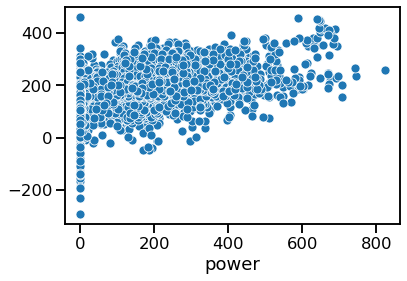

In [191]:
sns.scatterplot(target_test, predic_reg)

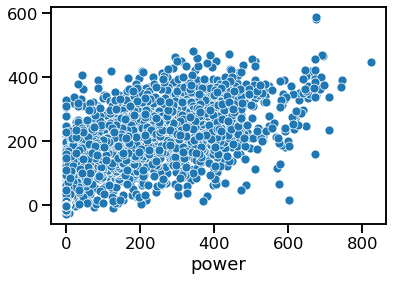

In [192]:
sns.scatterplot(target_test, predict_hgbdt)

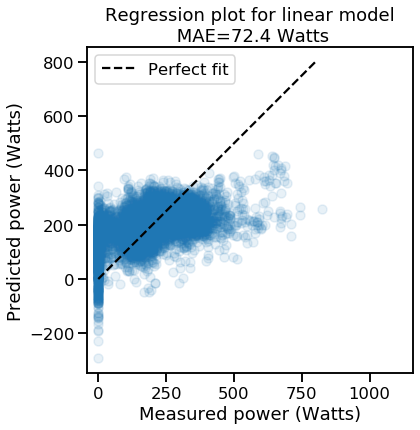

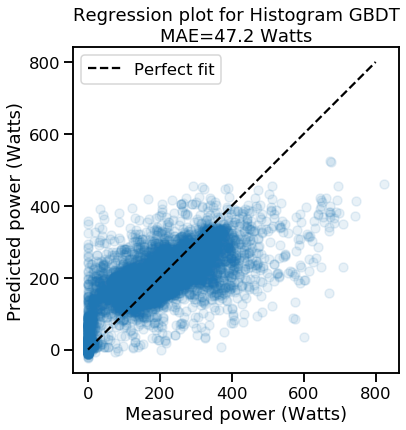

In [196]:
from sklearn.metrics import mean_absolute_error

# extract the dataset
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=date))[0]

data_linear_model_train = data_model.iloc[train_indices]
data_linear_model_test = data_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

# fit models and collect predictions
reg.fit(data_linear_model_train, target_train)
target_predicted_linear_model = reg.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

In [197]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

In [198]:
predict_subset_reg = reg.predict(data_test_linear_model_subset)
predict_subset_hgbdt = hgbdt.predict(data_test_subset)

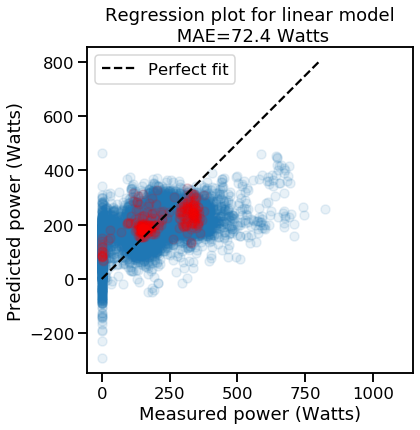

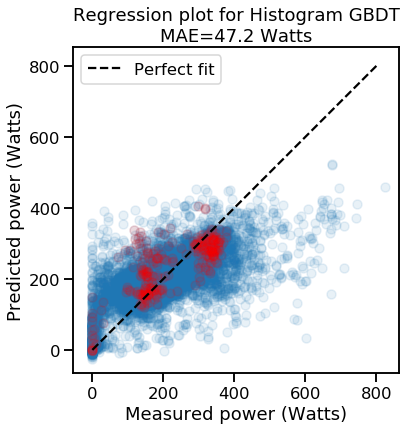

In [203]:
# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.scatter(target_test_subset, predict_subset_reg, alpha=.1, c="red")

plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")



plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.scatter(target_test_subset, predict_subset_hgbdt, alpha=.1, c="red")

plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")